In [1]:
#################################
# Importing necessary packages
#################################
from tqdm import tqdm
import pandas as pd 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import datetime


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.activations import relu,sigmoid, softmax
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam

2022-12-11 07:36:56.248420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 07:36:57.186836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-11 07:36:57.186958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

In [2]:
##################################
# Define the Train and Test path.
##################################
train_data_path = "data/train/"
test_data_path = "data/test/"

In [3]:
###############################################################
# Count of the avaiable samples of each class in the dataset.
###############################################################
action1_num_train = len(os.listdir(train_data_path+'Activity 1 - Walking/'))
action2_num_train = len(os.listdir(train_data_path+'Activity 2 - Sitting Down/'))
action3_num_train = len(os.listdir(train_data_path+'Activity 3 - Standing Up/'))
action4_num_train = len(os.listdir(train_data_path+'Activity 4 - Picking up object/'))

action1_num_test = len(os.listdir(test_data_path+'Activity 1 - Walking/'))
action2_num_test = len(os.listdir(test_data_path+'Activity 2 - Sitting Down/'))
action3_num_test = len(os.listdir(test_data_path+'Activity 3 - Standing Up/'))
action4_num_test = len(os.listdir(test_data_path+'Activity 4 - Picking up Object/'))

print("Training: Number of samples in each action")
print("walking: "+str(action1_num_train))
print("sitting down: "+str(action2_num_train))
print("standing up: "+str(action3_num_train))
print("picking: "+str(action4_num_train))

print("Test: Number of samples in each action")
print("walking: "+str(action1_num_test))
print("sitting down: "+str(action2_num_test))
print("standing up: "+str(action3_num_test))
print("picking: "+str(action4_num_test))

Training: Number of samples in each action
walking: 42
sitting down: 42
standing up: 42
picking: 32
Test: Number of samples in each action
walking: 10
sitting down: 10
standing up: 10
picking: 8


In [4]:
###################################
# Defining basic image parameters.
###################################
batch_size = 32
img_height = 180
img_width = 180

In [5]:
#####################################
# Training Split
#####################################
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 154 files belonging to 5 classes.
Using 124 files for training.


2022-12-11 07:36:59.801601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 07:36:59.808370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-11 07:36:59.809134: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping regist

In [6]:
################################
# Validation Split
################################
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 154 files belonging to 5 classes.
Using 30 files for validation.


In [7]:
##########################
# Test Split
##########################
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 38 files belonging to 5 classes.


In [8]:
######################################
# Printing out the class names.
######################################
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', 'Activity 1 - Walking', 'Activity 2 - Sitting Down', 'Activity 3 - Standing Up', 'Activity 4 - Picking up object']


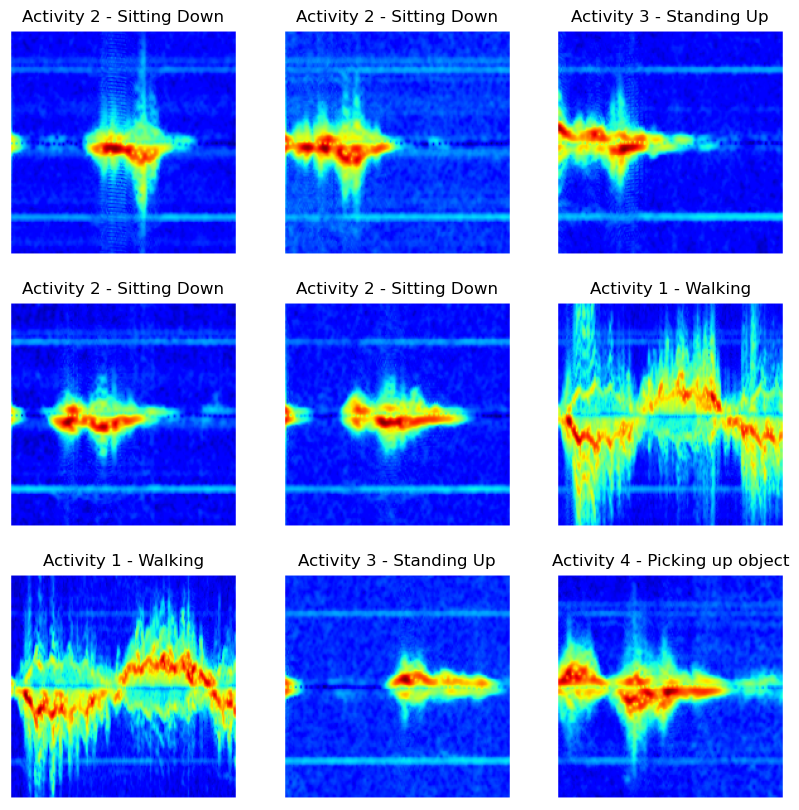

In [9]:
##############################################
# Plotting Samples from the dataset.
##############################################
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
##################################################
# Defining AUTOTUNE.
##################################################
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#################################
# Defining Normalization layer
#################################
normalization_layer = layers.Rescaling(1./255)

In [12]:
#########################################
# Applying normalization to the dataset.
#########################################
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [35]:
###########################################
# THe Model.
###########################################
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),  
  layers.MaxPooling2D(), 
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
##########################
# Compiling.
##########################
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
#########################
# Model Summary
#########################
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [38]:
#####################################
# Model Training.
#####################################
epochs=10
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks = [es]
)

# Saving the model.
model.save('my_model')


Epoch 1/10
4/4 [==============================] - 3s 499ms/step - loss: 1.4950 - accuracy: 0.4516 - val_loss: 1.0816 - val_accuracy: 0.5333
Epoch 2/10
4/4 [==============================] - 2s 466ms/step - loss: 0.8576 - accuracy: 0.5726 - val_loss: 0.8445 - val_accuracy: 0.7000
Epoch 3/10
4/4 [==============================] - 2s 459ms/step - loss: 0.5803 - accuracy: 0.7661 - val_loss: 0.6102 - val_accuracy: 0.6667
Epoch 4/10
4/4 [==============================] - 2s 458ms/step - loss: 0.3995 - accuracy: 0.8629 - val_loss: 0.4616 - val_accuracy: 0.8333
Epoch 5/10
4/4 [==============================] - 2s 482ms/step - loss: 0.2418 - accuracy: 0.8952 - val_loss: 0.2664 - val_accuracy: 0.9000
Epoch 6/10
4/4 [==============================] - 2s 462ms/step - loss: 0.1183 - accuracy: 0.9597 - val_loss: 0.1583 - val_accuracy: 0.9333
Epoch 7/10
4/4 [==============================] - 2s 464ms/step - loss: 0.0738 - accuracy: 0.9839 - val_loss: 0.1410 - val_accuracy: 0.9333
Epoch 8/10
4/4 [====

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


### Testing

In [39]:
####################################
# Fetching the test set.
####################################
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
################################
# Loading the Pre-Trained Model.
################################
loaded_model = tf.keras.models.load_model("my_model")

In [41]:
############################################
# Preparing the Dataset for creating classification report.
############################################
x_test = list()
y_test = list()
i = 0
for x_batch, y_batch in test_ds:
    x_test.extend(x_batch)
    y_test.extend(y_batch)
    i += 1
    if i==10:
        break
x_test = np.array(x_test)
y_test = np.array(y_test)

In [42]:
#############################################
# Generating a Classification_Report.
#############################################
from sklearn.metrics import classification_report

y_pred = loaded_model.predict(x_test, batch_size=64, verbose=1)
y_pred_final = list()
for i in range(len(y_pred)):
    argmax = np.argmax(y_pred[i])
    y_pred_final.append(argmax)
        
y_pred_final = np.array(y_pred_final)
print(classification_report(y_test, y_pred_final,target_names=['Walking','Sitting Down','Standing Up','Picking Up']))

1/1 [==============================] - 0s 212ms/step
              precision    recall  f1-score   support

     Walking       1.00      1.00      1.00        10
Sitting Down       1.00      0.90      0.95        10
 Standing Up       1.00      0.90      0.95        10
  Picking Up       0.80      1.00      0.89         8

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.96      0.95      0.95        38

